Данная работа посвящена решению обратной задачи восстановления коэффициента в уравнении Бюргерса по финальному наблюдению. 

Рассмотрим начально-краевую задачу для уравнения Бюргерса:

$$
\begin{aligned}
    &u_t = \epsilon u_{xx} + u u_x + q(x) u, t\in(0, T], x\in(0, 1) \\
    &u(x, 0) = u_0(x) \\
    &u(t, 0) = u_{l}, u(t, 1) = u_r
\end{aligned}
$$Обозначим $f(x) = u(x, T)$. Понятно, что $f(x) = f[q](x)$ некоторым образом зависит от коэффициента $q(x)$. Задача состоит в том, чтобы по наблюдаемому значению $f(x) = u(x, T)$ восстановить коэффициент $q(x)$. Для этого можно минимизировать функционал:
$$
J[q] = \int_{0}^1 \left( f(x)-q(x)\right)^2dx
$$

Рассмотрим сопряженную задачу:
$$
\begin{aligned}
    &\psi_t = -\epsilon \psi_{xx} + u \psi_x + q(x) \psi, t\in(0, T], x\in(0, 1) \\
    &\psi(x, T) = -2(u(x, T) - f(x)) \\
    &\psi(t, 0) = \psi(t, 1) = 0
\end{aligned}
$$

Можно [показать](https://www.youtube.com/watch?v=ZHJ7uyCIe9c&list=PLcsjsqLLSfNBFm8oU3tYav-gAbL57oUwl&index=3), что градиент функционала $J[q]$ вычисляется через решение сопряженной задачи по следующей формуле:
$$
J'[q](x) = \int_{0}^T u(x, t) \psi(x, t) dt
$$

Для увеличения устойчивости задачи можно добавить регуляризацию:
$$
J[q] = \int_{0}^1 \left( f(x)-q(x)\right)^2dx + \alpha \int_0^1 q^2 dx + \beta \int_0^1 q'^2 dx
$$Градиент второго слагаемого равен $2\alpha q$, третьего: $-2\beta q''$.
Для минимизации функционала будем использовать методы градиентного спуска, сопряженных градиентов и быстрый градиентный метод Нестерова.


В данной работе прямая и сопряженная задача решаются численно. Для их решения используется жесткий метод прямых. Вначале вводится сетка по переменной $x$: $x_n = nh, h = \dfrac{1}{N}$ и сеточные функции: $u_n(t) = u(x_n, t)$. Затем пространственные производные заменяются на конечные разности, в итоге для $u_n(t)$ получим систему ОДУ:

$$
\begin{aligned}
&\begin{cases}
    &u_0(t) = u_l \\
    &\dfrac{du_n}{dt} = \epsilon \dfrac{u_{n-1}-2u_n+u_{n+1}}{h^2} + u \dfrac{u_{n+1}-u_{n-1}}{2h} + q(x_n) u_n\\
    &u_N(t) = u_r
\end{cases}\\
&u_n(0) = u_0(x_n)
\end{aligned}
$$

Аналогично для сопряженной задачи. Полученная задача является жесткой, для её решения будем использовать схему Розенброка с комплексным коэффициентом. Она имеет второй порядок точности по шагу по времени $\tau$ и является устойчивой. Схема Розенброка в общем виде записывается следующим образом:

$$
\begin{aligned}
&\dfrac{d\vec{y}}{dt} = \vec{F}\\
&(E - \vec{F}_y a_{11} \tau) w = \vec{F} \\
&y(t+\tau) = y + \tau \Re w
\end{aligned}
$$

Здесь $a_{11}$ -- параметр схемы, $\vec{F}$ -- вектор правых частей, $\vec{F}_y$ -- якобиан. При $a_{11}=0$ получаем явную схему, при $a_{11}=1$ получаем неявную схему, причем для решения нелинейного уравнения мы используем одну итерацию метода Ньютона, при $a_{11}=\dfrac{1+1i}{2}$ получаем комплексную схему Розенброка со вторым порядком точности.

В приведённых выше задачах якобиан оказывается трёхдиагональным, так что один шаг схемы Розенброка сводится к решению СЛАУ с трёхдиагональной матрицей, что можно сделать эффективно с помощью алгоритма [прогонки](https://ru.wikipedia.org/wiki/Метод_прогонки). Таким образом, общая сложность решения исходной или сопряженной задачи есть $O(MN)$, где $M$ -- число узлов по времени, $N$ -- по пространству.


Обратные задачи характерны тем, что нам необходимо много раз решать прямую и сопряженную задачу. Для ускорения вычислений воспользуемся библиотекой [numba](https://habr.com/ru/post/484136/), которая позволяет компилировать отдельные функции, что ускоряет вычисление при частом их вызове.

In [1]:
import numpy as np
from numba import jit, njit
from matplotlib import pyplot as plt
from matplotlib import animation, rc

from tqdm import tqdm

In [2]:
@njit
def prog(a, b, c, f):
    '''
        Функция для решения СЛАУ с трёхдиагноальной матрицей
    '''
    n = len(f)
    v = np.zeros_like(f)
    x = np.zeros_like(f)
    
    w = a[0]
    x[0] = f[0] / w
    for i in range(1, n):
        v[i - 1] = c[i - 1] / w
        w = a[i] - b[i] * v[i - 1]
        x[i] = (f[i] - b[i] * x[i - 1]) / w
    for i in range(n-2, -1, -1):
         x[i] = x[i] - v[i] * x[i + 1]
    return x

In [3]:
@njit
def solve_burgers(N, M, xn, hn, tau, epsilon, u_left, u_right, a_11, q):
    '''
        Функция решения прямой задачи
    '''
    u = np.zeros((N+1))
    res = np.zeros((M + 1, N + 1))#матрица M+1, N+1 хранящяя сеточные значения u(t_m, x_n)
    u = -8 + 12 * xn
    res[0, :] = u
    eh2 = epsilon / (h ** 2)
    a, b, c, F = np.zeros((N-1), np.complex_), np.zeros((N-1), np.complex_), np.zeros((N-1), np.complex_), np.zeros((N-1), np.complex_)
    for m in range(M):
        for n in range(1, N):
            b[n-1] = 0 - a_11 * tau * (eh2 - u[n]/2/h)
            c[n-1] = 0 - a_11 * tau * (eh2 + u[n]/2/h)
            a[n-1] = 1 - a_11 * tau * (-2 * eh2 - (u[n+1]-u[ n-1])/2/h - q[n])
            F[n-1] = eh2 * (u[n + 1] - 2 * u[n] + u[n - 1]) + u[n] * (u[n+1]-u[n-1])/2/h - q[n] * u[n]
        w = prog(a, b, c, F)
        for n in range(1, N):
            u[n] = u[n] + tau * w[n - 1].real;
        u[0] = u_left
        u[N] = u_right
        res[m + 1, :] = u
    return res

In [4]:
@njit
def solve_sopr(N, M, xn, h, tau, epsilon, a_11, q, u, f_obs):
    '''
        Функция решения сопряженной задачи
    '''
    res = np.zeros((M + 1, N + 1))#матрица M+1, N+1 хранящяя сеточные значения psi(t_m, x_n)
    psi = -2 * (u[M, :] - f_obs)
    res[M, :] = psi
    a, b, c, F = np.zeros((N-1), np.complex_), np.zeros((N-1), np.complex_), np.zeros((N-1), np.complex_), np.zeros((N-1), np.complex_)
    eh2 = epsilon / (h ** 2)
    tau = -tau
    for m in range(M, 0, -1):
        for n in range(1, N):
            b[n-1] = 0 - a_11 * tau * (-eh2 - u[m, n]/2/h)
            c[n-1] = 0 - a_11 * tau * (-eh2 + u[m, n]/2/h)
            a[n-1] = 1 - a_11 * tau * (2 * eh2 + q[n])
            F[n-1] = -eh2 * (psi[n + 1] - 2 * psi[n] + psi[n - 1]) + u[m, n] * (psi[n+1]-psi[n-1])/2/h + q[n] * psi[n]
        w = prog(a, b, c, F)
        for n in range(1, N):
            psi[n] = psi[n] + tau * w[n - 1].real;
        psi[0] = 0
        psi[N] = 0
        res[m - 1, :] = psi
    return res

In [64]:

def calc_grad(N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_beta, f_obs, q):
    '''
        Функция вычисления градиента. Интегралы заменяются квадратурными формулами трапеций. 
        Производные также берутся численно.
    '''
    #решаем прямую задачу
    u = solve_burgers(N, M, xn, h, tau, epsilon, u_left, u_right, a_11, q)
    #решаем сопряженную
    psi = solve_sopr(N, M, xn, h, tau, epsilon, a_11, q, u, f_obs)
    #находим их произведение
    m = u * psi
    #находим градиент основного функционала(интеграл u * psi по t)
    grad = tau * np.sum(m[1:-1, :], axis=0) + tau * 0.5 * (m[0, :] + m[-1, :])
    #градиент регуляризации с q
    grad_alpha = reg_alpha * 2.0 * q
    #градиент регуляризации с q'. вторая производная заменена на конечную разность
    grad_beta = np.zeros((N+1))
    grad_beta[1:-1] = reg_beta * 2.0 * (2 * q[1:-1] - q[0:-2] - q[2:]) / h
    #возвращаем сумму градиентов и финальное значение(оно нужно для вычисления функционала)
    return grad + grad_alpha + grad_beta, u[-1, :]

In [65]:
def Gradient_Desc(N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_beta,f_obs):
    '''
        Решение задачи оптимизации методом градиентного спуска.
    '''
    q = np.zeros((N+1))
    z = q
    qs = np.zeros((N_iter+1, N + 1))
    qs[0, :] = q
    error = np.zeros((N_iter))
    for s in tqdm(range(N_iter)):
        grad, u_last = calc_grad(N, M, xn, h, tau, epsilon, u_left, u_right, a_11, 
                                 reg_alpha, reg_beta, f_obs, q)
        q = q - alpha * grad
        error[s] = np.linalg.norm(f_obs-u_last)**2
        qs[s+1, :] = q
    return error, qs

In [180]:
def Nesterov_gradient(N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_beta,f_obs):
    '''
        Решение задачи оптимизации методом быстрого градиентного спуска.
    '''
    q = np.zeros((N+1))
    z = q
    qs = np.zeros((N_iter+1, N + 1))
    qs[0, :] = q
    error = np.zeros((N_iter))
    for s in tqdm(range(N_iter)):
        grad, u_last = calc_grad(N, M, xn, h, tau, epsilon, u_left, u_right, a_11, 
                                 reg_alpha, reg_beta, f_obs, q)
        q_new = z - alpha * grad;
        k = s % 100 + 1
        k = s
        z = q_new + k / (k + 3) * (q_new - q);
        q = q_new;
        error[s] = np.linalg.norm(f_obs-u_last)**2;
        qs[s+1, :] = q;
    return error, qs


def Nesterov_gradient_D1_reg(N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_betas, f_obs):
    q = np.zeros((N+1))
    z = q
    qs = [q]
    N_iter_ = N_iter // len(reg_betas)
    N_iter = N_iter_ * len(reg_betas)
    error = np.zeros((N_iter))
    i = 0
    for reg_beta in reg_betas:
        for s in tqdm(range(N_iter_)):
            grad, u_last = calc_grad(N, M, xn, h, tau, epsilon, u_left, u_right, a_11, 
                                     reg_alpha, reg_beta, f_obs, q)
            q_new = z - alpha * grad;
            #k = s % 100 + 1
            k = s
            z = q_new + k / (k + 3) * (q_new - q)
            q = q_new
            error[i] = np.linalg.norm(f_obs-u_last)**2
            qs.append(q)
            i += 1
    return error, qs

In [67]:
def Conj_gradient(N_iter, alpha, N, M, xn, ht, tau, epsilon, u_left, u_right, a_11, 
                  reg_alpha, reg_beta, f_obs):
    '''
        Решение задачи оптимизации методом сопряженных градиентов.
    '''
    q = np.zeros((N+1))
    qs = np.zeros((N_iter+1, N + 1))
    qs[0, :] = q
    error = np.zeros((N_iter))
    
    grad, u_last = calc_grad(N, M, xn, ht, tau, epsilon, u_left, u_right, a_11, 
                             reg_alpha, reg_beta,f_obs, q)
    h = -grad
    prev_norm = np.linalg.norm(h) ** 2
    for s in tqdm(range(N_iter)):
        grad, u_last = calc_grad(N, M, xn, ht, tau, epsilon, u_left, u_right, a_11,
                                 reg_alpha, reg_beta, f_obs, q)
        cur_norm = np.linalg.norm(grad)**2
        if s % N == 0:
            beta = 0
        else:
            beta = cur_norm / prev_norm
        h = -grad + beta * h
        q = q + alpha * h
        error[s] = np.linalg.norm(f_obs-u_last)**2
        qs[s+1, :] = q
        prev_norm = cur_norm
    return error, qs

In [68]:
def get_grid(N, x_left, x_right):
    N2 = N // 2
    x1 = x_left + (x_right - x_left) * 0.75
    xn1 = np.linspace(x_left, x1, N2, endpoint=False)
    xn2 = np.linspace(x1, x_right, N2 + 1)
    return np.concatenate((xn1, xn2))

In [69]:
#Параметры модели

epsilon = 0.5  # Задаём малый парамет \varepsilon

x_left = 0     # Задаём левую границу области по координате
x_right = 1    # Задаём правую границу области по координате

N = 100       # Задаём число интервалов сетки по пространству N
M = 150        # Задаём число интервалов сетки по времени M

T = 1;  # Определяем время счёта

h = (x_right - x_left)/N   # Вычисляем величину шага по координате
xn = np.linspace(x_left, x_right, N + 1)    # Формируем сетку по координате
#xn = get_grid(N, x_left, x_right)
#hn = xn[1:] - xn[:-1]
tau = (T - 0)/M            # Вычисляем величину шага по времени
tm = np.linspace(0, T, M + 1)         # Формируем сетку по времени

u_left = -8       #Задаём левое граничное условие        
u_right = 4        # Задаём правое гарничное условие

# Параметр, отвечающий за свойства схемы:
a_11 = 0.5 + 1j * 0.5

reg_alpha = 0
reg_beta = 1e-7

q_fun = lambda x: np.sin(3 * np.pi * x)

q0 = q_fun(xn)

In [11]:
#задаём f(t)
u = solve_burgers(N, M, xn, h, tau, epsilon, u_left, u_right, a_11, q0)
f_obs = u[-1, :]

In [41]:
#параметры оптимизаторов. величина шага и число итераций
alpha = 0.01
N_iter = 10000

args = (N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_beta, f_obs)

In [13]:
error_desc, qs_decs = Gradient_Desc(*args)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 774.15it/s]


In [14]:
error_fast, qs_fast = Nesterov_gradient(*args)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 930.72it/s]


In [15]:
error_conj, qs_conj = Conj_gradient(*args)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 933.27it/s]


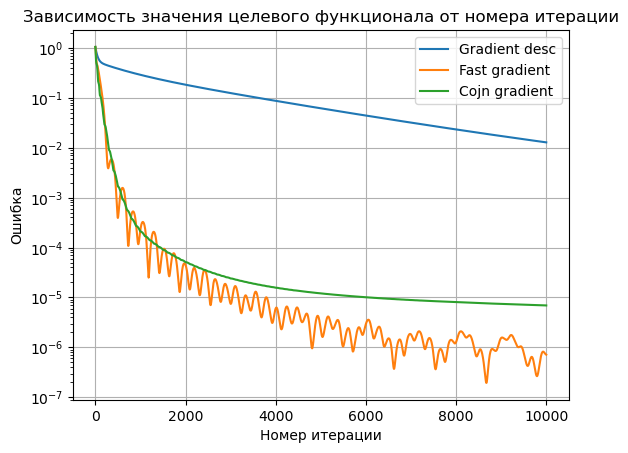

In [16]:
niter = np.arange(N_iter)
plt.semilogy(niter, error_desc, label='Gradient desc')
plt.semilogy(niter, error_fast, label='Fast gradient')
plt.semilogy(niter, error_conj, label='Cojn gradient')
plt.grid()
plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("Ошибка")
plt.title("Зависимость значения целевого функционала от номера итерации")
plt.show()

Видно, что метод сопряженных градиентов и быстрый градиентный метод быстрее обычного градиентного спуска. Дальнейшие эксперементы будем проводить с быстрым градиентным методом. Посмотрим, как восстановился коэффициент $q(x)$. На графиках видно, что обычный градиентный спуск не успел хорошо приблизить $q(x)$, остальные два метода справились более менее хорошо, но они хуже восстановили последний участок, где $x \geq 0.8$. Попробуем добавить регуляризацию.

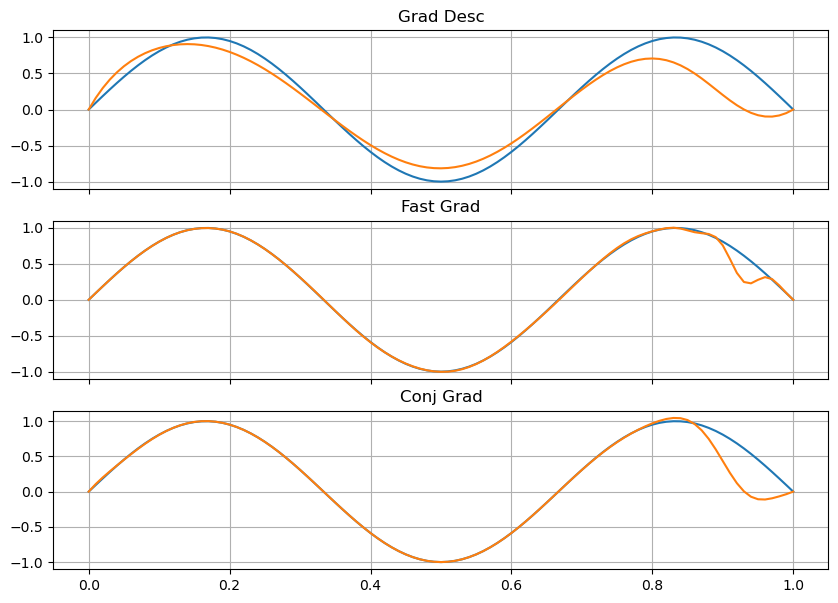

In [17]:
# Create two subplots and unpack the output array immediately
f, (ax2, ax3, ax4) = plt.subplots(3, 1, sharex=True, figsize=(10, 7))
ax2.plot(xn, q0, xn, qs_decs[-1, :])
ax2.grid()
ax3.plot(xn, q0, xn, qs_fast[-1, :])
ax3.grid()
ax4.plot(xn, q0, xn, qs_conj[-1, :])
ax4.grid()
ax2.set_title("Grad Desc")
ax3.set_title("Fast Grad")
ax4.set_title("Conj Grad")
plt.show()

In [118]:
reg_alphas = 10.0 ** np.arange(-8, 1)
N_iter = 1000
qs = []
errors = []

for reg_alpha in reg_alphas:
    args = (N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_beta, f_obs)
    er_temp, q_temp = Nesterov_gradient(*args)
    qs.append(q_temp[-1, :])
    errors.append(er_temp)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 915.91it/s]


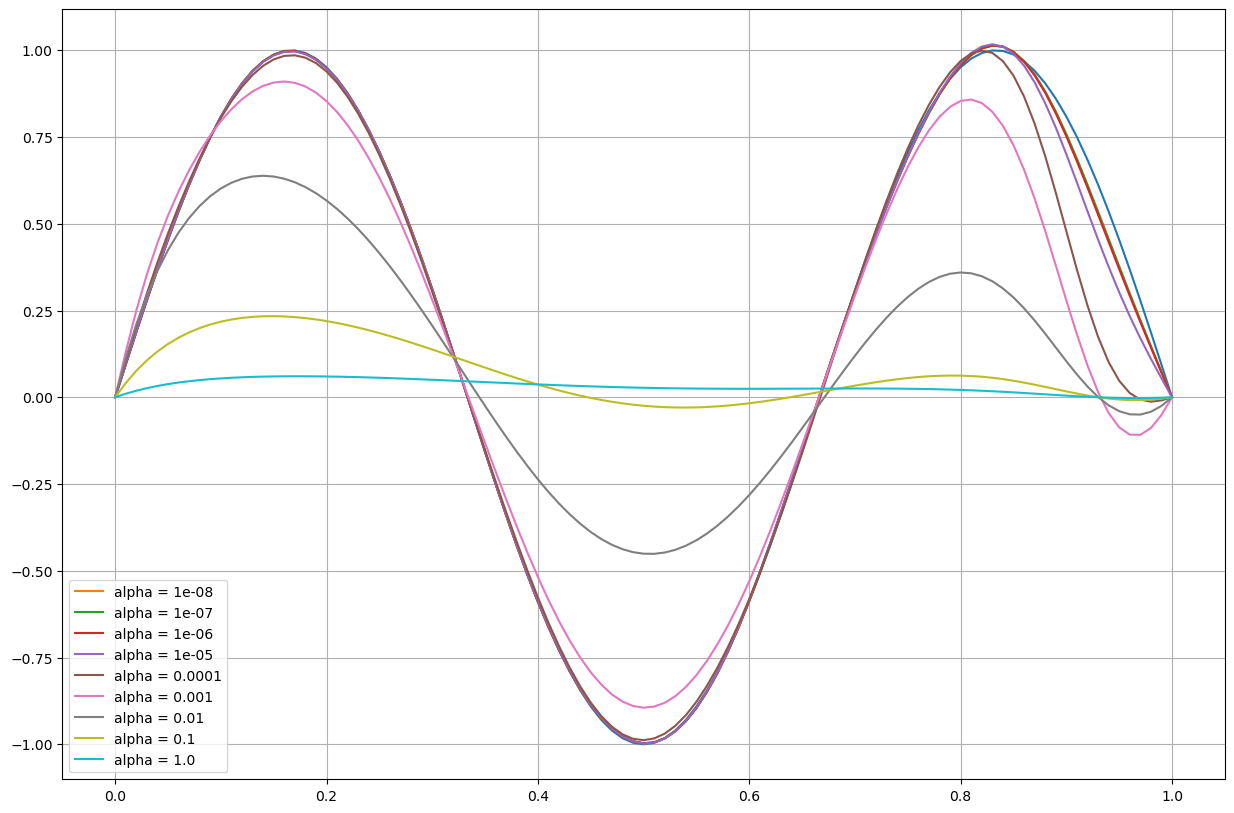

In [119]:
plt.figure(figsize=(15, 10))
plt.plot(xn, q0)
for reg_alpha, q, err in zip(reg_alphas, qs, errors):
    plt.plot(xn, q, label=f'alpha = {reg_alpha}')
plt.grid()
plt.legend()
plt.show()

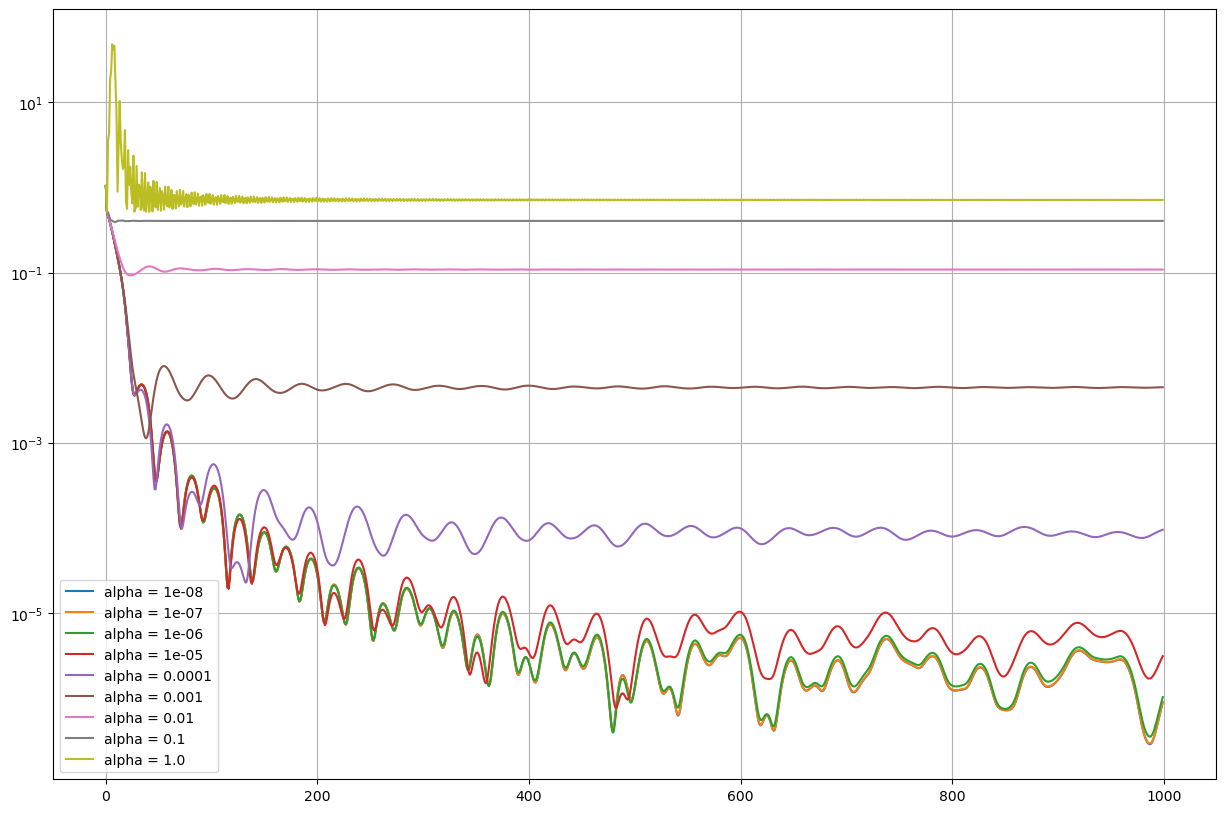

In [120]:
plt.figure(figsize=(15, 10))
niter = np.arange(N_iter)
for alpha, err in zip(reg_alphas, errors):
    plt.semilogy(niter, err, label=f'alpha = {alpha}')
plt.grid()
plt.legend()
plt.show()

Видно, что при больших коэффициентах регуляризации решение зануляется, маленькие тоже не помогают. Попробуем регуляризацию производной:

In [121]:
reg_alpha = 1e-6

reg_betas = [1e-7, 1e-6, 1e-5]
N_iter = 5000
qs_beta = []
errors_beta = []

for reg_beta in reg_betas:
    args = (N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11, reg_alpha, reg_beta, f_obs)
    er_temp, q_temp = Nesterov_gradient(*args)
    qs_beta.append(q_temp[-1, :])
    errors_beta.append(er_temp)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 959.26it/s]


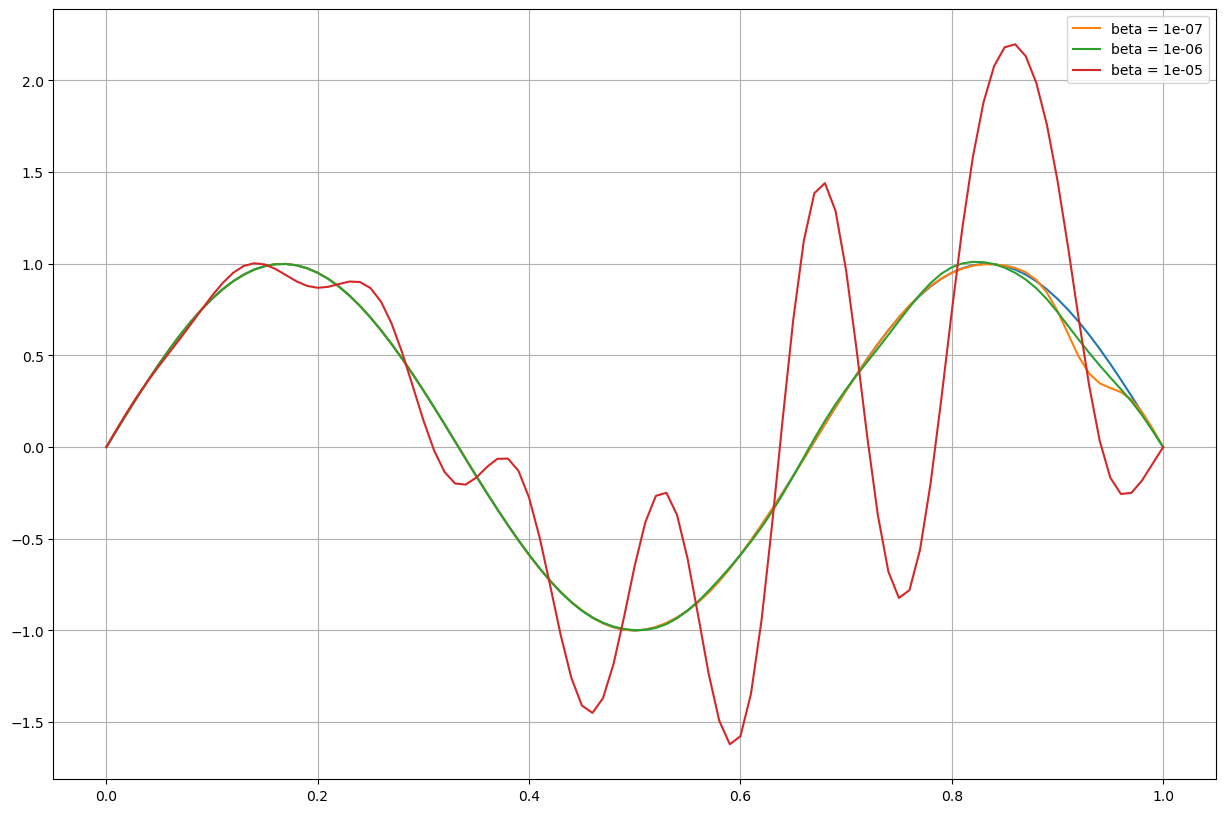

In [122]:
plt.figure(figsize=(15, 10))
plt.plot(xn, q0)
for reg_beta, q in zip(reg_betas, qs_beta):
    plt.plot(xn, q, label=f'beta = {reg_beta}')
plt.grid()
plt.legend()
plt.show()

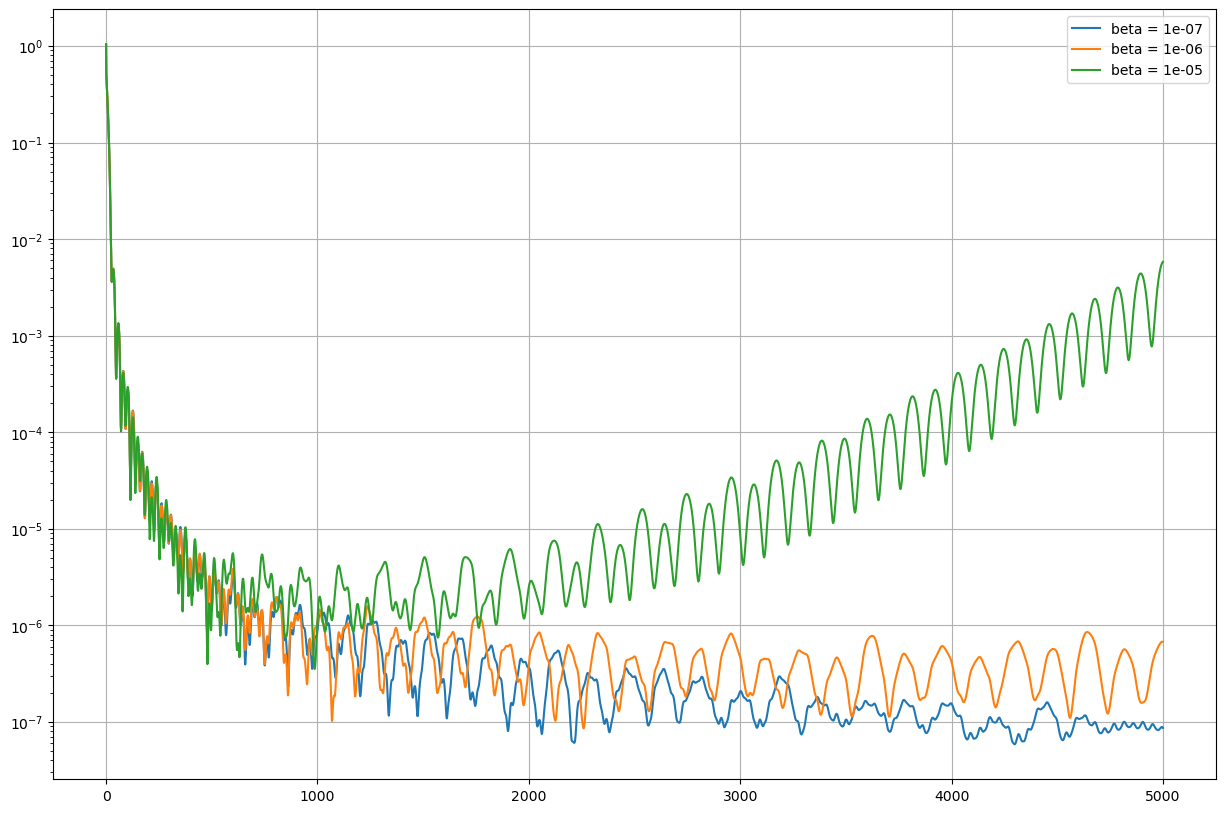

In [123]:
plt.figure(figsize=(15, 10))
niter = np.arange(N_iter)
for reg_beta, err in zip(reg_betas, errors_beta):
    plt.semilogy(niter, err, label=f'beta = {reg_beta}')
plt.grid()
plt.legend()
plt.show()

Видно, что при некоторых $\beta$ функционал убывает не монотонно. Попробуем проделать следующую процедуру: зададим массив убывающих параметров регуляризации $\beta_i$, и запустим оптимизацию, последовательно уменьшая параметр регуляризации.

In [198]:
reg_betas = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
reg_alpha = 0.0

In [199]:
N_iter = 20000
error_fast, qs_fast = Nesterov_gradient_D1_reg(N_iter, alpha, N, M, xn, h, tau, epsilon, u_left, u_right, a_11,
                                        reg_alpha, reg_betas, f_obs)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 852.50it/s]


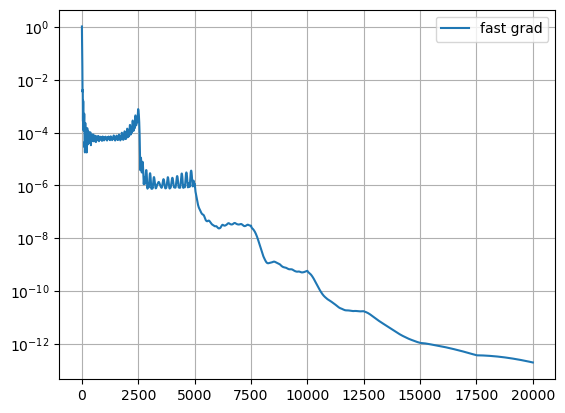

In [200]:
niter = np.arange(N_iter)
plt.semilogy( error_fast, label='fast grad')
plt.grid()
plt.legend()
plt.show()
None

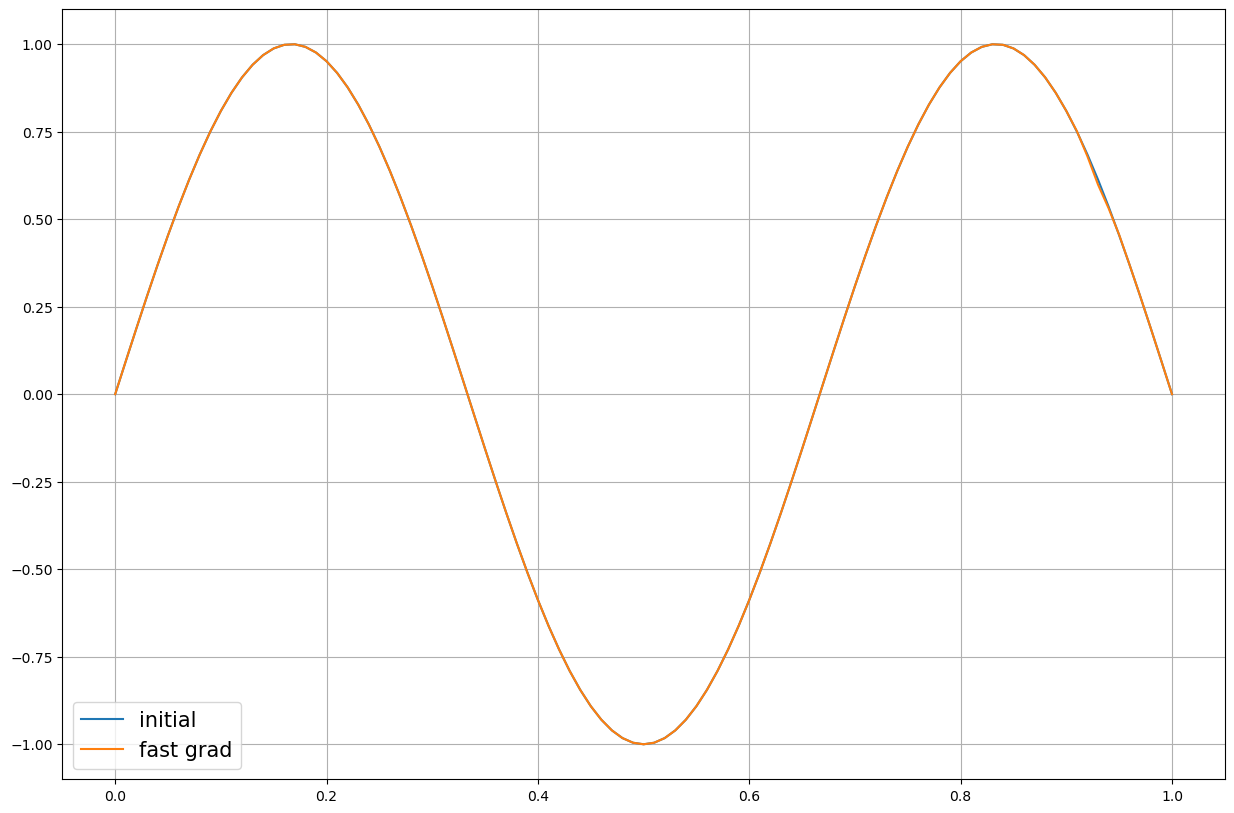

In [201]:
plt.figure(figsize=(15, 10))
plt.plot(xn, q0, label='initial')
plt.plot(xn, qs_fast[-1], label='fast grad')
plt.grid()
plt.legend(fontsize=15)
plt.show()
None

Видно, что такой подход позволил значительно улучшить качество решения и избавил нас от возмущений в районе $x=0.9$.